## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

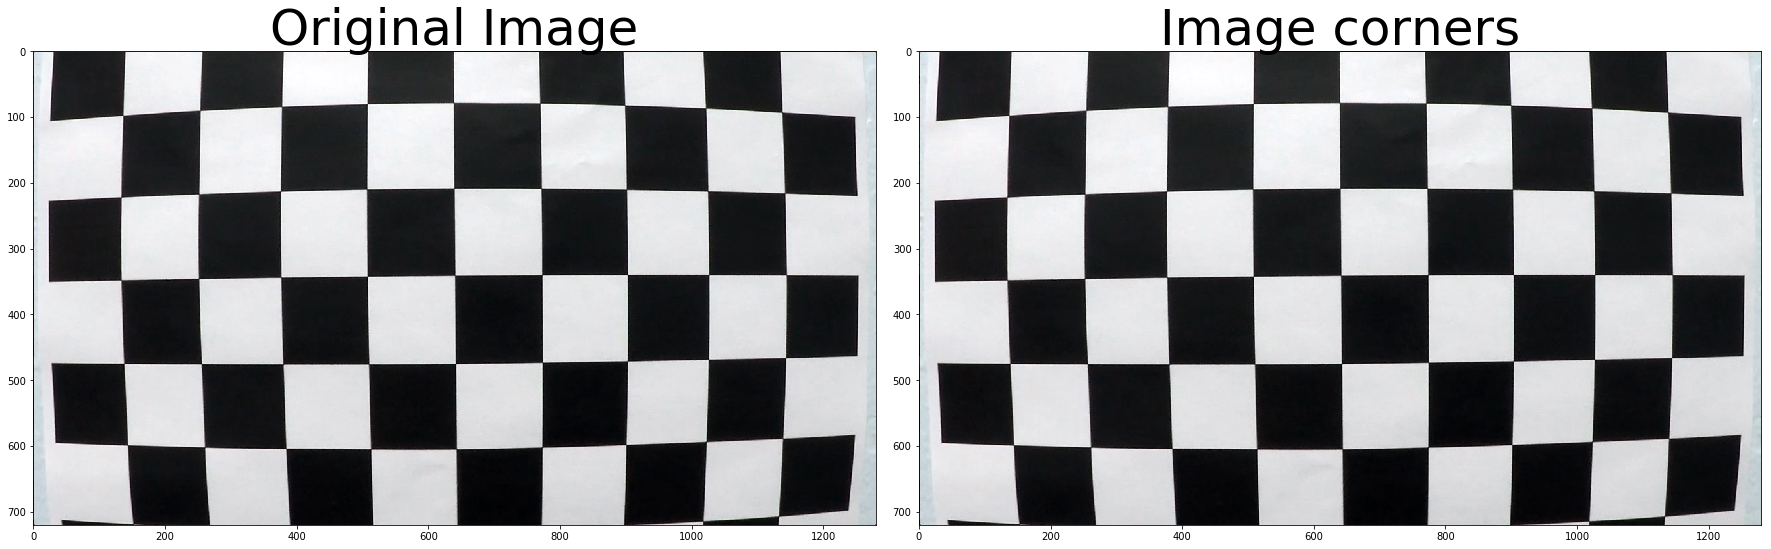

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Draw and display the corners
cal_img = cv2.imread('../camera_cal/calibration1.jpg')
gray = cv2.cvtColor(cal_img,cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
img = cv2.drawChessboardCorners(cal_img, (9,6), corners, ret)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img)
ax2.set_title('Image corners', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/chessboard_corners.jpg")
       

In [5]:
# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (cal_img.shape[1], cal_img.shape[0]), None, None)
def cal_undistort(img):
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

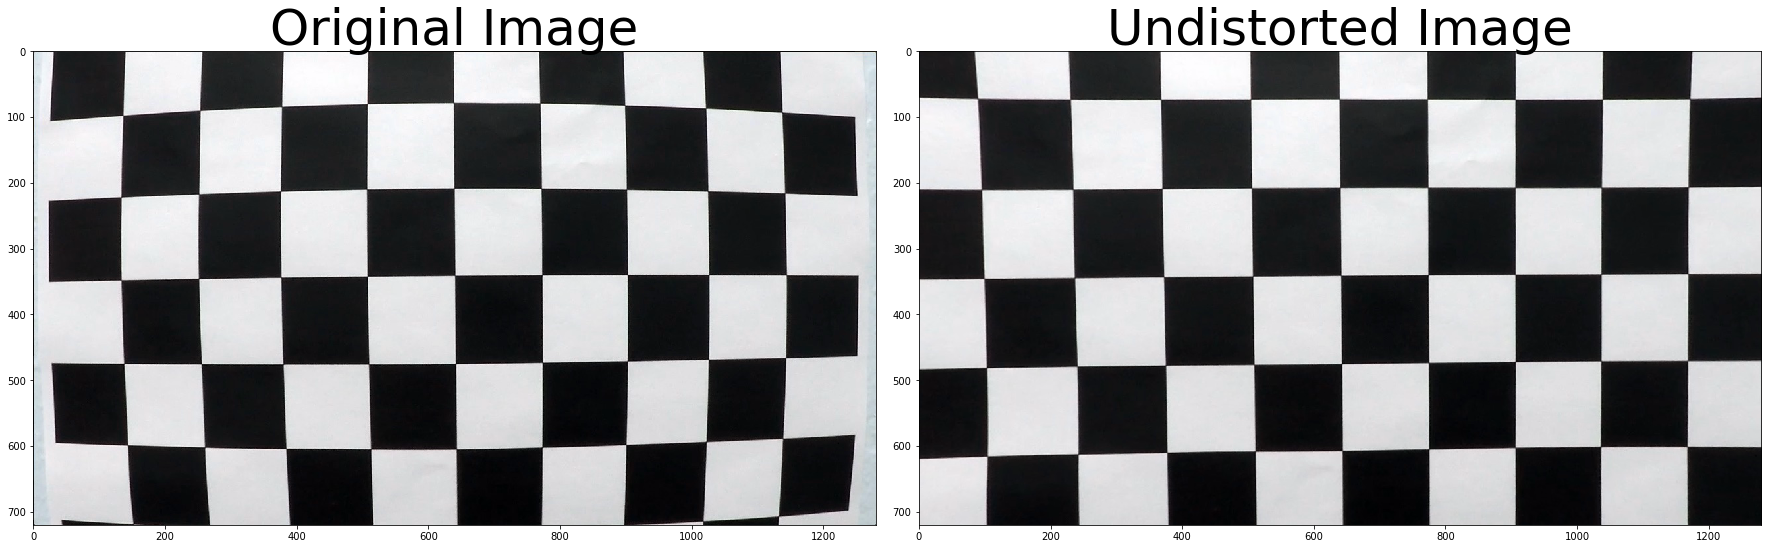

In [6]:
# Make a list of test images
chessboard_cal = cv2.imread('../camera_cal/calibration1.jpg')
undistorted_cal = cal_undistort(chessboard_cal)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(chessboard_cal)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_cal)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/Undistorted_chess_board.jpg")


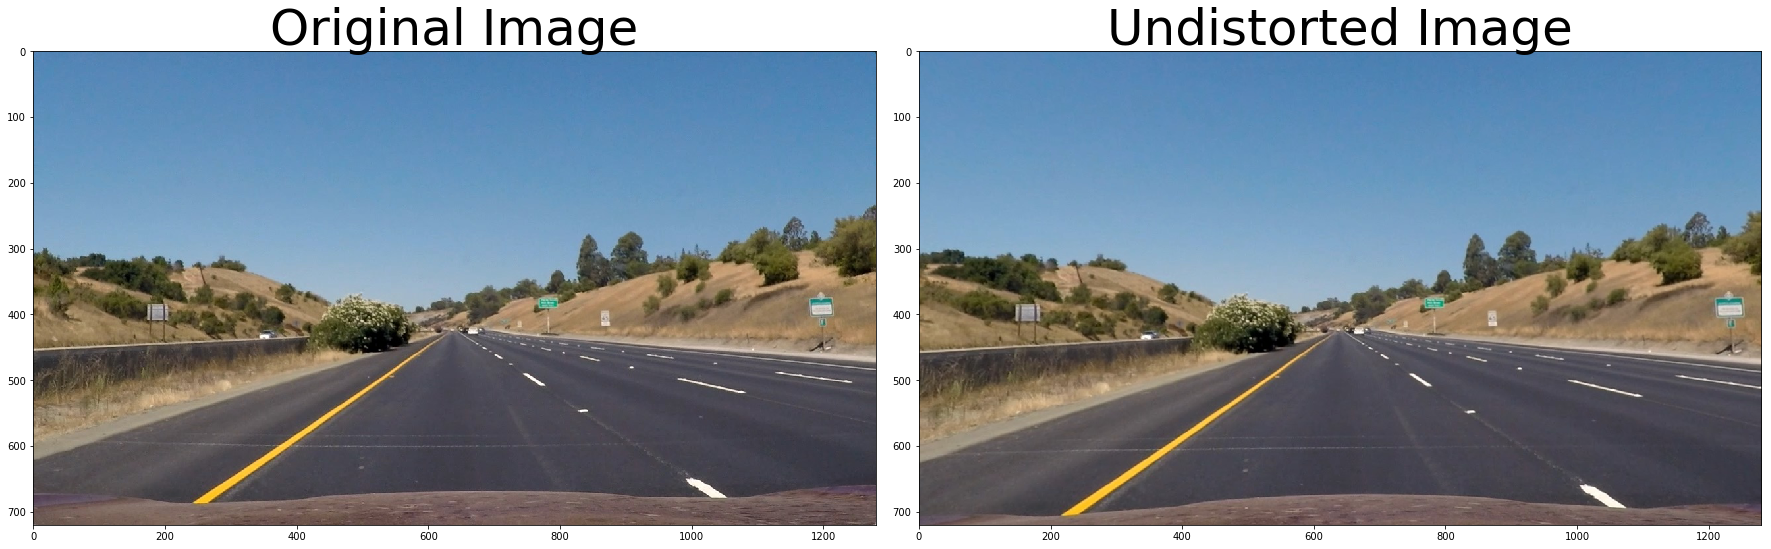

In [7]:
# Read and undistort a test image
image = mpimg.imread('../test_images/straight_lines1.jpg')
undist = cal_undistort(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/Undistorted_road_image.jpg")

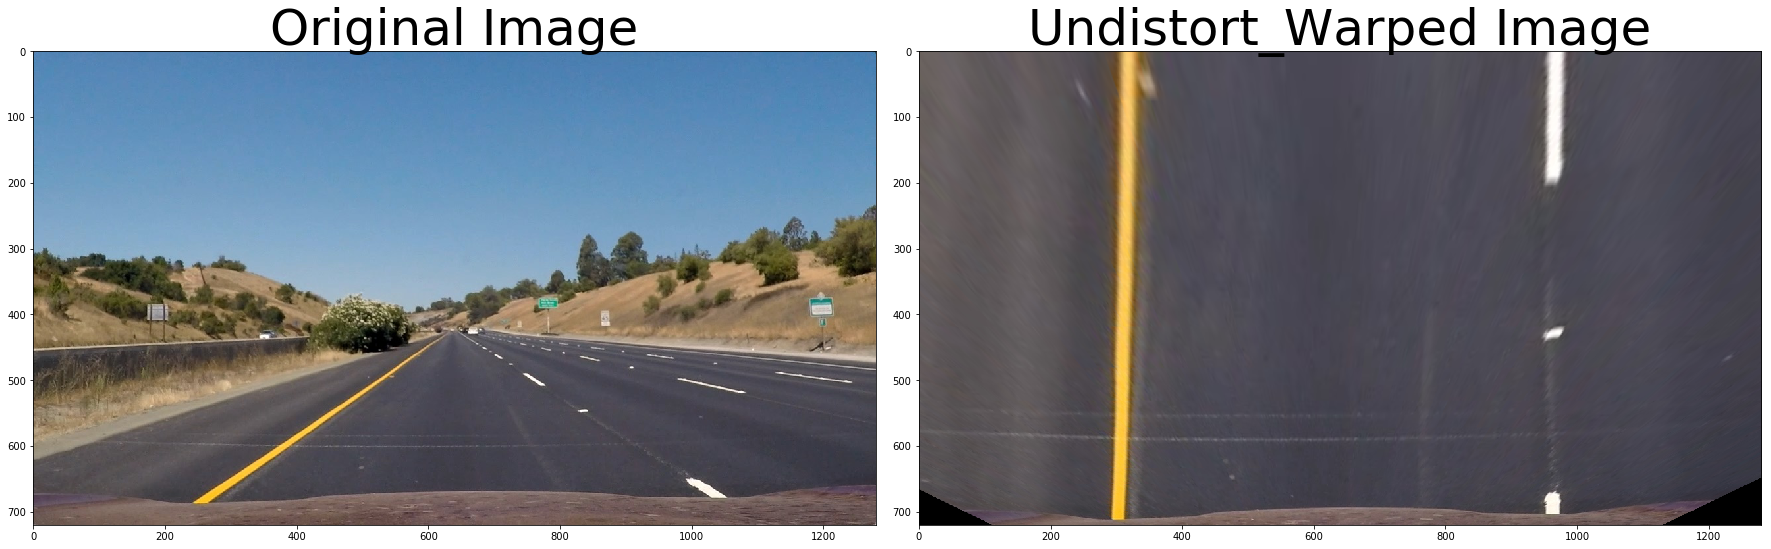

In [27]:
# Perspective transoform of images
src = np.float32([[470,490], 
                  [758,490], 
                  [1100,685], 
                  [10,685]])
dst = np.float32([[100,0], 
                  [1000,0], 
                  [1000,710], 
                  [100,710]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


def pers_transform(img):
#    undistort = cal_undistort(img)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

undistort_warped = cal_undistort(image)
undistort_warped = pers_transform(undistort_warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(pers_transform(image))
ax2.set_title('Undistort_Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/Undis_warp_road_image.jpg")

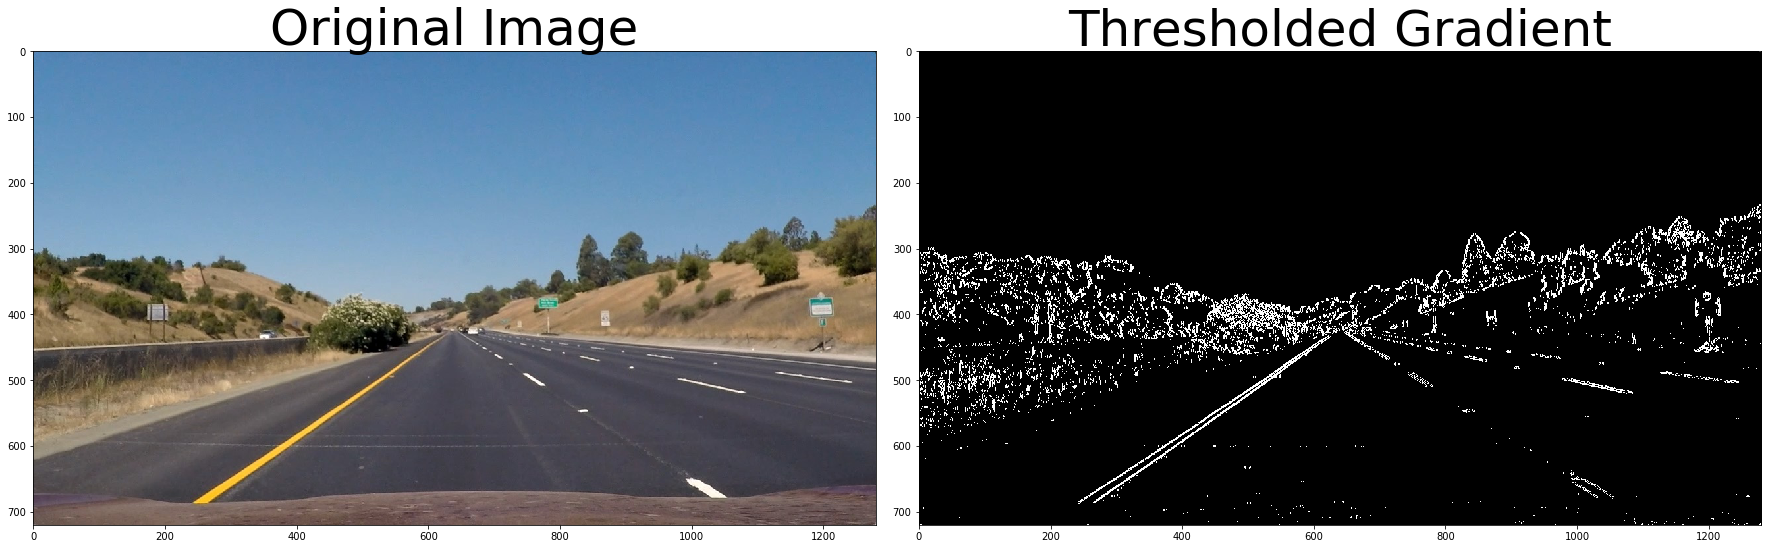

In [28]:
# Sobel thresh
def abs_sobel_thresh(img, orient='x', kernel_size=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1,0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0,1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>np.min(thresh)) & (scaled_sobel<np.max(thresh))] = 1
    return binary_output
    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/threshed_gradient_road_image.jpg")

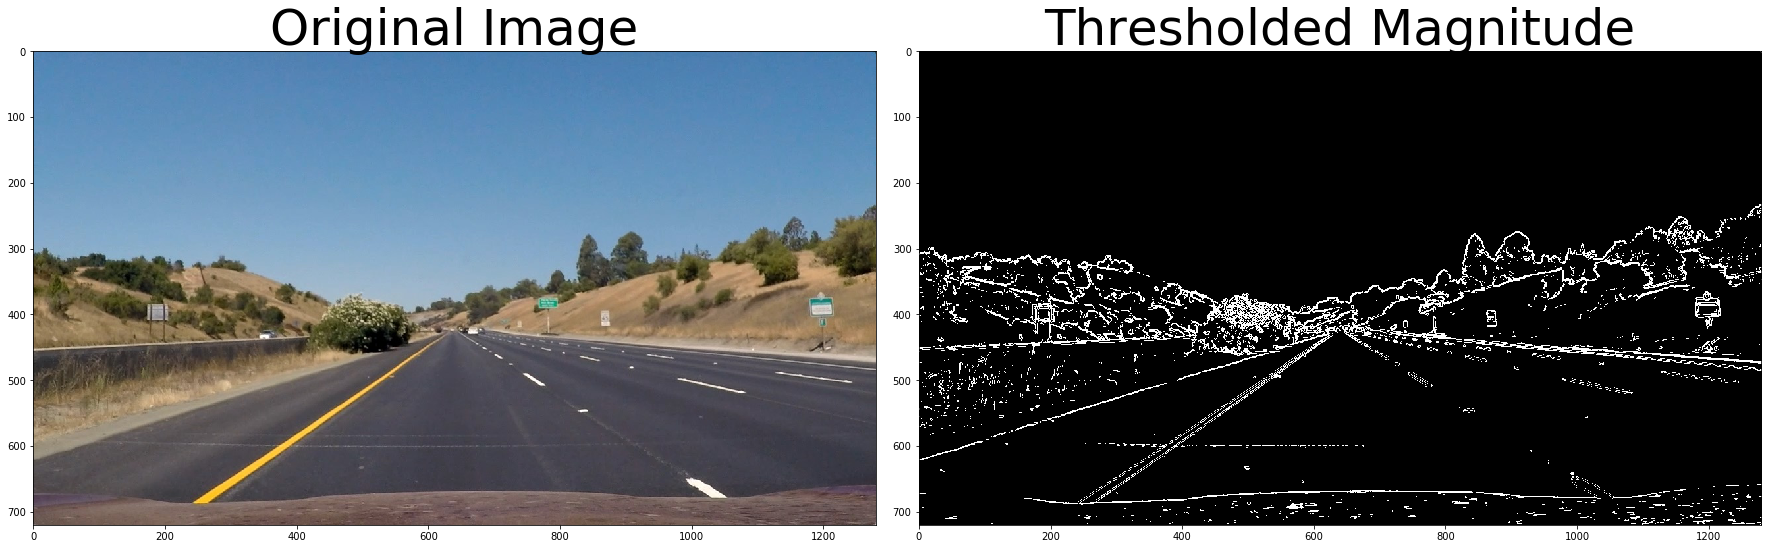

In [29]:
# Magitude of gradient
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, kernel_size=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1,0))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0,1))
    mag_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_mag = (255*mag_sobelxy)/np.max(mag_sobelxy)
    sobelxy = np.uint8(scaled_mag)
    binary_output = np.zeros_like(sobelxy)
    binary_output[(sobelxy>np.min(thresh)) & (sobelxy<np.max(thresh))] = 1
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, kernel_size=9, thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/threshed_magnitude_road_image.jpg")

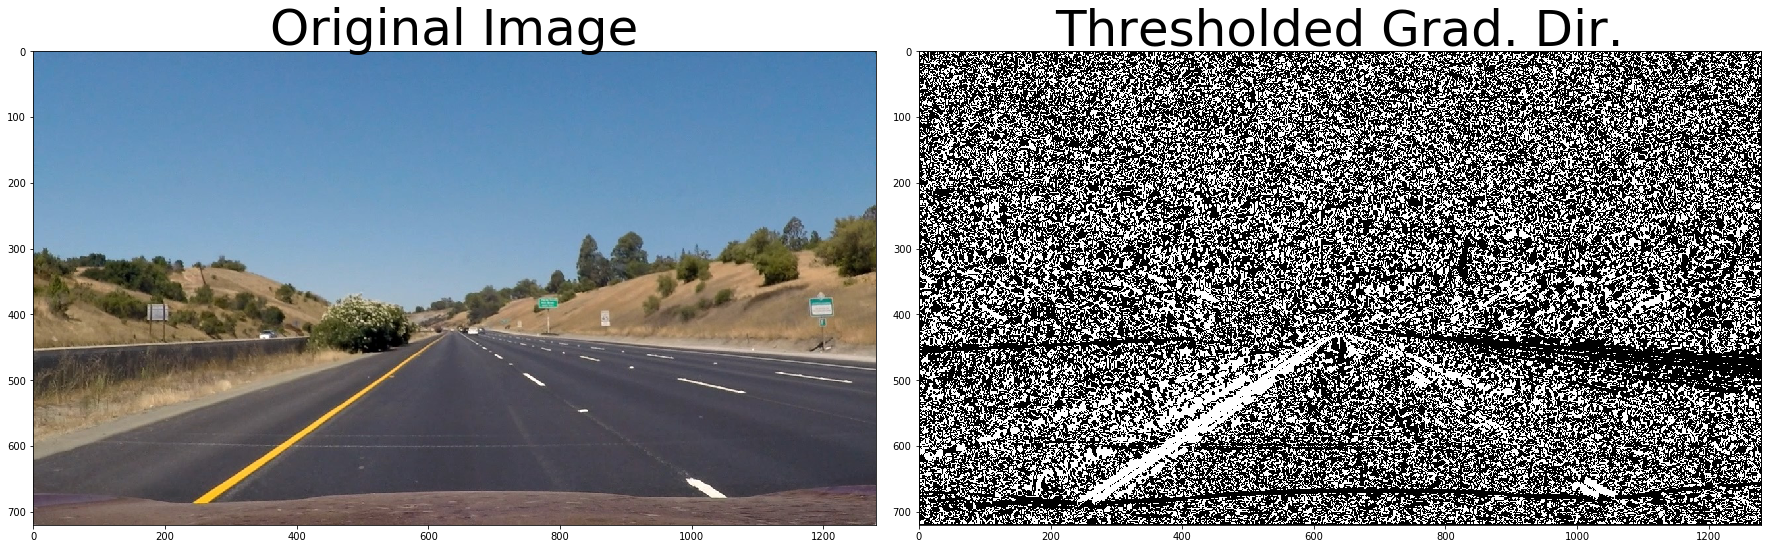

In [30]:
# Direction thresh

def dir_threshold(img, kernel_size=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0, ksize=kernel_size))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1, ksize=kernel_size))
    dir_grad = np.arctan2(abs_sobely,abs_sobelx)
    binary_output = np.zeros_like(gray)
    binary_output[(dir_grad>np.min(thresh))&(dir_grad<np.max(thresh))] = 1
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, kernel_size=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/threshed_grad_dir_road_image.jpg")

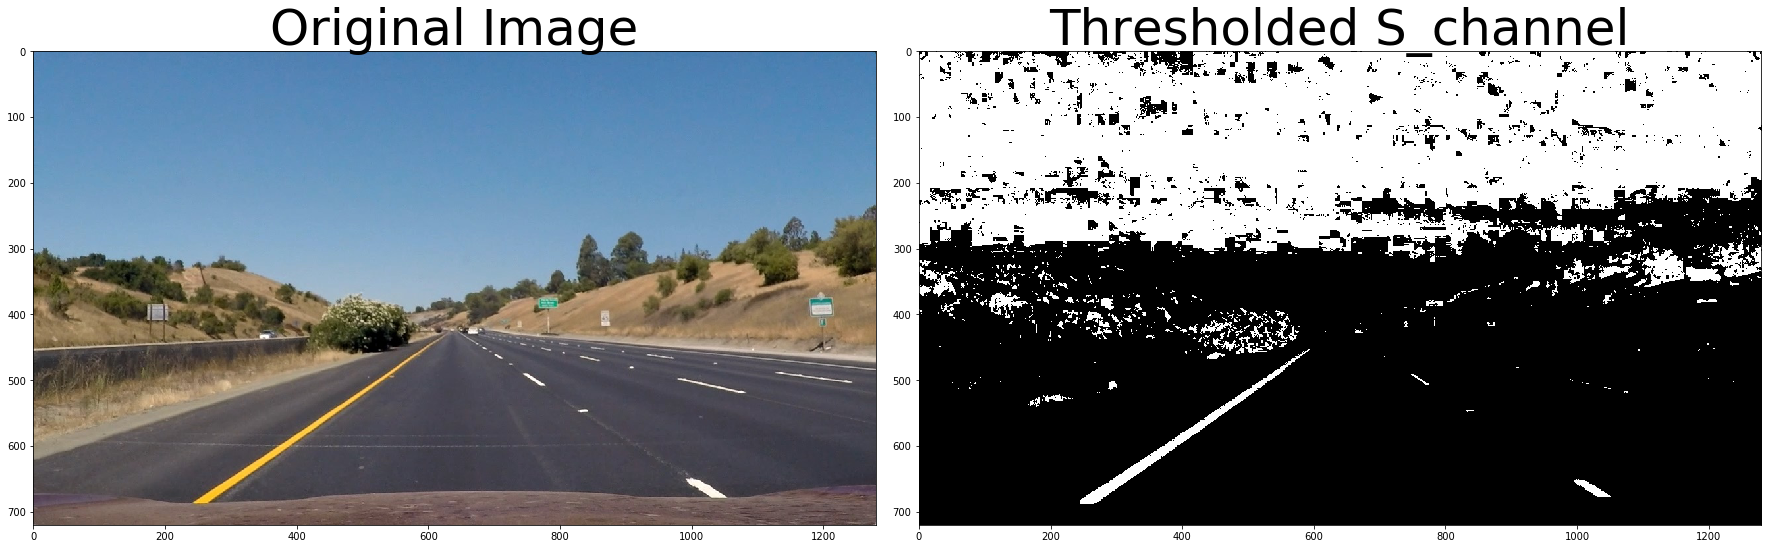

In [31]:
# Convert to HLS color space and separate the V channel
def s_thresh(img, kernel_size=3, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

# Run the function
s_binary = s_thresh(image, kernel_size=3, thresh=(100, 255))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('Thresholded S_channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("../output_images/s_channel_road_image.jpg")

In [35]:
# Pipeline

def pipeline(image):
    # Image read and color space covert
#    img = np.copy(image)
    undist = cal_undistort(image)
    img = pers_transform(undist)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
    # Thresh
    thresh_sobel = (20, 100)
    thresh_mag = (30, 100)
    thresh_dir = (0.7, 1.5)
    thresh_s = (100, 255)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', kernel_size=ksize, thresh=thresh_sobel)
    grady = abs_sobel_thresh(img, orient='y', kernel_size=ksize, thresh=thresh_sobel)
    mag_binary = mag_thresh(img, kernel_size=ksize, thresh= thresh_mag)
    dir_binary = dir_threshold(img, kernel_size=ksize, thresh=thresh_dir)
    s_binary = s_thresh(img, kernel_size=ksize, thresh=thresh_s)

    #Combined binary
    warped_binary = np.zeros_like(s_binary)
#    w_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    warped_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    return warped_binary, undist
    #img, mag_binary, dir_binary, s_binary
''' 
warped_binary, img, mag_binary, dir_binary, s_binary = pipeline(image)

# Plot the result
f, ax = plt.subplots(2, 3, figsize=(24, 9))

ax[0,0].imshow(image)
ax[0,0].set_title('Original image', fontsize=20)
ax[0,1].imshow(mag_binary, cmap='gray')
ax[0,1].set_title('Magnitude thresh', fontsize=20)
ax[0,2].imshow(dir_binary, cmap='gray')
ax[0,2].set_title('Dir thresh', fontsize=20)
ax[1,0].imshow(s_binary, cmap='gray')
ax[1,0].set_title('S_channel', fontsize=20)
ax[1,1].imshow(warped_binary, cmap='gray')
ax[1,1].set_title('Warped threshes', fontsize=20)
ax[1,2].imshow(img)
ax[1,2].set_title('Warped image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
#plt.savefig("../output_images/combined_threshes_road_image.jpg")
'''

' \nwarped_binary, img, mag_binary, dir_binary, s_binary = pipeline(image)\n\n# Plot the result\nf, ax = plt.subplots(2, 3, figsize=(24, 9))\n\nax[0,0].imshow(image)\nax[0,0].set_title(\'Original image\', fontsize=20)\nax[0,1].imshow(mag_binary, cmap=\'gray\')\nax[0,1].set_title(\'Magnitude thresh\', fontsize=20)\nax[0,2].imshow(dir_binary, cmap=\'gray\')\nax[0,2].set_title(\'Dir thresh\', fontsize=20)\nax[1,0].imshow(s_binary, cmap=\'gray\')\nax[1,0].set_title(\'S_channel\', fontsize=20)\nax[1,1].imshow(warped_binary, cmap=\'gray\')\nax[1,1].set_title(\'Warped threshes\', fontsize=20)\nax[1,2].imshow(img)\nax[1,2].set_title(\'Warped image\', fontsize=20)\nplt.subplots_adjust(left=0., right=1, top=1, bottom=0.)\n#plt.savefig("../output_images/combined_threshes_road_image.jpg")\n'

In [38]:
# Search laneline with histogram
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

def blind_search(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty, nonzeroy, nonzerox, left_lane_inds, right_lane_inds
#    print('leftx has the size of ', leftx.shape)
#    print('rightx has the size of ', rightx.shape)
#    print('ploty has the size of ', ploty.shape)
print('...')

...


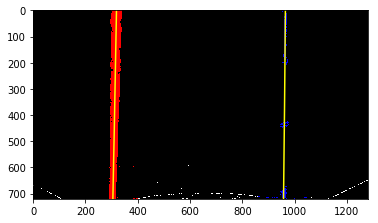

In [39]:
# Plot the image with windows and lanelines
# Generate x and y values for plotting
image = mpimg.imread('../test_images/straight_lines1.jpg')
combined_binary, undist = pipeline(image)
left_fitx, right_fitx, ploty, nonzeroy, nonzerox, left_lane_inds, right_lane_inds = blind_search(combined_binary)
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("../output_images/laneline_road_image.jpg")

In [40]:
# Next frame search
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def next_frame(img):
    binary_warped = img
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty
#    print('leftx has the size of ', leftx.shape)
#    print('rightx has the size of ', rightx.shape)
#    print('ploty has the size of ', ploty.shape)
print('...')

...


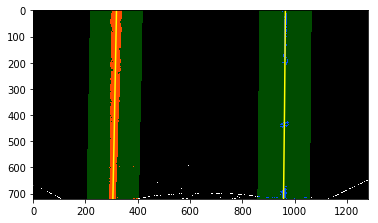

In [41]:
# Plot laneline window
# Create an image to draw on and an image to show the selection window
binary_warped = combined_binary
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

margin = 100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.flipud(np.transpose(np.vstack([left_fitx-margin, ploty])))])
left_line_window2 = np.array([np.transpose(np.vstack([left_fitx+margin, 
                              ploty]))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("../output_images/laneline_margin_road_image.jpg")

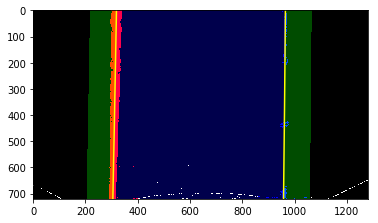

In [42]:
# Plot lane
lane_line_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
lane_line_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
lane_line_pts = np.hstack((lane_line_left, lane_line_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([lane_line_pts]), (0,0,255))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("../output_images/laneline_margin_road_image.jpg")

In [43]:
# Calculate curvature of lanelines and car offset 
# Define conversions in x and y from pixels space to meters
def get_param(left_fitx, right_fitx, ploty, nonzeroy, nonzerox, left_lane_inds, right_lane_inds):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad + right_curverad)/2
    lane_center = (left_fitx[0] + right_fitx[0])/2
    car_center = binary_warped.shape[1]/2
    car_offset = abs(lane_center - car_center)*xm_per_pix
    # Now our radius of curvature is in meters
    return car_center, lane_center, curvature, car_offset
    

In [44]:
# Create an image to draw the lines on
def map_to_road(binary_warped, undist, car_center, lane_center, curvature, car_offset):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    lane_line_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    lane_line_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    lane_line_pts = np.hstack((lane_line_left, lane_line_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([lane_line_pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Annotate image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
    if (car_center > lane_center) & (car_offset > 0.1):
        text = 'Vehicle is {:.0f} m right of lane!' .format(car_offset)
        cv2.putText(result, text, (100,100), font, 1, (255,255,255), 2)
    elif (car_center < lane_center) & (car_offset > 0.1):
        text = 'Vehicle is {:.0f} m left of lane!' .format(car_offset)
        cv2.putText(result, text, (100,100), font, 1, (255,255,255), 2)
    else:
        text = 'Vehicle is at the center of lane!'
        cv2.putText(result, text, (100,100), font, 1, (255,255,255), 2)
    text = 'Radius of curvature is {:.0f} m' .format(curvature)
    cv2.putText(result, text, (100,140), font, 1, (255,255,255), 2)
    return result   
''' 
    plt.imshow(result)
    if (car_center > lane_center) & (car_offset > 0.1):
        plt.text(100, 100, 'Vehicle is {:.0f} m right of lane!' .format(car_offset))
    elif (car_center < lane_center) & (car_offset > 0.1):
        plt.text(100, 100, 'Vehicle is {:.0f} m left of lane!' .format(car_offset))
    else:
        plt.text(100, 100, 'Vehicle is at the center of lane!')
    plt.text(100,140, 'Radius of curvature is {:.0f} m' .format(curvature))
#    plt.savefig("../output_images/lane_marked_road_image.jpg")
'''

' \n    plt.imshow(result)\n    if (car_center > lane_center) & (car_offset > 0.1):\n        plt.text(100, 100, \'Vehicle is {:.0f} m right of lane!\' .format(car_offset))\n    elif (car_center < lane_center) & (car_offset > 0.1):\n        plt.text(100, 100, \'Vehicle is {:.0f} m left of lane!\' .format(car_offset))\n    else:\n        plt.text(100, 100, \'Vehicle is at the center of lane!\')\n    plt.text(100,140, \'Radius of curvature is {:.0f} m\' .format(curvature))\n#    plt.savefig("../output_images/lane_marked_road_image.jpg")\n'

In [45]:
## Video precessing pipeline
def image_pipeline(img):
#    image = img.copy()
    combined_binary, undist = pipeline(img) # process the image to get the combined binary
    left_fitx, right_fitx, ploty, nonzeroy, nonzerox, left_lane_inds, right_lane_inds = blind_search(combined_binary) # search for lanes
    car_center, lane_center, curvature, car_offset = get_param(left_fitx, right_fitx, ploty, nonzeroy, nonzerox, left_lane_inds, right_lane_inds) # get cuvature and car offset
    road = map_to_road(combined_binary, undist, car_center, lane_center, curvature, car_offset) # draw lane onto road!
    plt.imshow(road)

TypeError: Image data cannot be converted to float

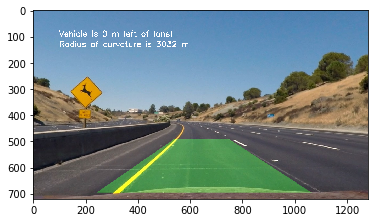

In [46]:
# Test the image pipe on test image
test_image = mpimg.imread('../test_images/test2.jpg')
test_image_result = image_pipeline(test_image)
plt.imshow(test_image_result)

AttributeError: 'NoneType' object has no attribute 'shape'

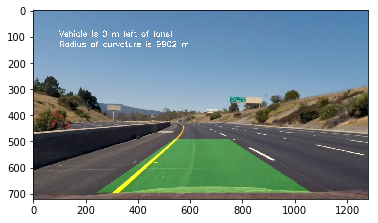

In [47]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
video_processed = video_input.fl_image(image_pipeline)
%time video_processed.write_videofile(video_output, audio=False)